In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
plt.ion()

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import cluster 
import sys
import numpy as np
import csv

path_to_mitie_lib = '/opt/anaconda/anaconda3/lib/python3.6/site-packages/mitie'
path_to_ner_model = '/home/somnus/MITIE-master/MITIE-models/english/ner_model.dat'

sys.path.append(path_to_mitie_lib)

from mitie import *
from itertools import cycle, islice
from sklearn.decomposition import PCA

In [3]:
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state, check_symmetric, check_array
from scipy import sparse

In [4]:
from sklearn.manifold.spectral_embedding_ import _graph_is_connected, _set_diag
import warnings

In [5]:
from sklearn.neighbors import kneighbors_graph

In [6]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [7]:
ner = named_entity_extractor(path_to_ner_model)

In [8]:
# total number of articles to process
N = 662

# in memory stores for the topics, titles and contents of the news stories
# topics_array = []
titles_array = []
corpus = []

In [9]:
# Correct this for titles a

file_path = ['data_sets/articles_1/article-',
             'data_sets/sci_art/article-',
             '/home/somnus/data_sets/DataSet/article-',
            '/home/somnus/data_sets/nyt/Cclimate/article-']

In [10]:
for i in range(0, N):

    # get the contents of the article
    # art = '/home/somnus/data_sets/articles/article-' + str(i) + '.txt'
    x = str(i)
    with open(file_path[3] + x + '.txt', 'r') as myfile:
        d1 = myfile.read()
        d1 = d1.lower()
        corpus.append(d1)

    # get the title of the article
    # titl = '/home/somnus/data_sets/articles/title-' + str(i) + '.txt'
    with open(file_path[3] + x + '.txt', 'r') as myfile:
        ti1 = myfile.read()
        ti1 = ti1.lower()
        titles_array.append(ti1)


In [11]:
entity_text_array = []

for i in range(0, N):

    # Load the article contents text file and convert it into a list of words.
    tokens = tokenize(corpus[i])
    #tokens = tokenize(corpus)


    # extract all entities known to the ner model mentioned in this article
    entities = ner.extract_entities(tokens)

    # extract the actual entity words and append to the array
    for e in entities:
        range_array = e[0]
        tag = e[1]
        score = e[2]
        score_text = "{:0.3f}".format(score)
        # entity_text = " ".join(tokens[j] for j in range_array)
        entity_text = " ".join(tokens[i].decode() for i in range_array)
        entity_text_array.append(entity_text.lower())
        
# remove duplicate entities detected
entity_text_array = np.unique(entity_text_array)

In [12]:
vect = TfidfVectorizer(sublinear_tf=True,
                       max_df=0.5,
                       analyzer='word',
                       stop_words='english',
                       vocabulary=entity_text_array)

# corpus_tf_idf = vect.fit_transform(corpus)

X = vect.fit_transform(corpus).todense()

In [13]:
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)

In [14]:
def spectral_clustering(affinity, n_clusters=8, n_components=None,
                        eigen_solver=None, random_state=None, n_init=10,
                        eigen_tol=0.0, assign_labels='kmeans', normed='False'):
    if assign_labels not in ('kmeans', 'discretize'):
        raise ValueError("The 'assign_labels' parameter should be "
                     "'kmeans' or 'discretize', but '%s' was given"
                     % assign_labels)

    random_state = check_random_state(random_state)
    n_components = n_clusters if n_components is None else n_components
    maps = spectral_embedding(affinity, n_components=n_components,
                              eigen_solver=eigen_solver,
                              random_state=random_state,
                              eigen_tol=eigen_tol, drop_first=False,
                              normed=normed)
    if assign_labels == 'kmeans':
        _, labels, _ = cluster.k_means(maps, n_clusters, random_state=random_state, n_init=10)

    return labels

In [15]:
def spectral_embedding(adjacency, n_components=8, eigen_solver=None,
                       random_state=None, eigen_tol=0.0,
                       norm_laplacian=True, drop_first=True, normed=False):
    adjacency = check_symmetric(adjacency)

    try:
        from pyamg import smoothed_aggregation_solver
    except ImportError:
        if eigen_solver == "amg":
            raise ValueError("The eigen_solver was set to 'amg', but pyamg is "
                             "not available.")

    if eigen_solver is None:
        eigen_solver = 'arpack'
    elif eigen_solver not in ('arpack', 'lobpcg', 'amg'):
        raise ValueError("Unknown value for eigen_solver: '%s'."
                         "Should be 'amg', 'arpack', or 'lobpcg'"
                         % eigen_solver)

    random_state = check_random_state(random_state)

    n_nodes = adjacency.shape[0]
    # Whether to drop the first eigenvector
    if drop_first:
        n_components = n_components + 1

    if not _graph_is_connected(adjacency):
        warnings.warn("Graph is not fully connected, spectral embedding"
                      " may not work as expected.")

    laplacian, dd = sparse.csgraph.laplacian(adjacency, normed=normed,
                                             return_diag=True)
    if (eigen_solver == 'arpack' or eigen_solver != 'lobpcg' and
       (not sparse.isspmatrix(laplacian) or n_nodes < 5 * n_components)):

        laplacian = _set_diag(laplacian, 1, norm_laplacian)
        #print(laplacian)
        laplacian_array.append(laplacian)
        diag_array.append(dd)

        try:

            laplacian *= -1
            v0 = random_state.uniform(-1, 1, laplacian.shape[0])
            lambdas, diffusion_map = sparse.linalg.eigsh(laplacian, k=n_components,
                                                         sigma=1.0, which='LM',
                                                         tol=eigen_tol, v0=v0)
            
            eigen_values.append(lambdas)
            eigen_vectors.append(diffusion_map)
            embedding = diffusion_map.T[n_components::-1] * dd
            embedding_array.append(embedding)
            
            
        except RuntimeError:

            eigen_solver = "lobpcg"
            laplacian *= -1
    if drop_first:
        return embedding[1:n_components].T
    else:
        return embedding[:n_components].T

In [16]:
n_clusters = 3
eigen_solver = None
random_state = None
n_init = 10
gamma = 1
affinity = 'rbf'
n_neighbors = 2
eigen_tol = 0.0
assign_labels = 'kmeans'
degree = 3
coef0 = 1
kernel_params = None
n_jobs = 1
lap = False

In [17]:
eigen_values = []
eigen_vectors = []
embedding_array = []
laplacian_array = []
diag_array = []

data2D_checked = check_array(data2D, accept_sparse=['csr', 'csc', 'coo'], dtype=np.float64)

if X.shape[0] == X.shape[1] and self.affinity != "precomputed":
    warnings.warn("The spectral clustering API has changed. ``fit``"
                  "now constructs an affinity matrix from data. To use"
                  " a custom affinity matrix, "
                  "set ``affinity=precomputed``.")
params = kernel_params
if params is None:
    params = {}
if not callable(affinity):
    params['gamma'] = 1
    params['degree'] = 3
    params['coef0'] = 1
affinity_matrix_ = pairwise_kernels(data2D_checked, metric=affinity, filter_params=True, **params)
random_state = check_random_state(random_state)
labels_ = spectral_clustering(affinity_matrix_,
                              n_clusters=n_clusters,
                              eigen_solver=eigen_solver,
                              random_state=random_state,
                              n_init=n_init,
                              eigen_tol=eigen_tol,
                              assign_labels=assign_labels,
                             normed='norm_laplacian')


In [18]:
cluster_assignments = labels_.astype(np.int)
data = list()

for i in range(0, len(cluster_assignments)):
    data.append([int(i), int(cluster_assignments[i]), str(titles_array[i])])


In [19]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                    '#f781bf', '#a65628', '#984ea3',
                                    '#999999', '#e41a1c', '#dede00']),
                                    int(max(cluster_assignments) + 1))))

Text(0.5,1,'Spectral Clustering')

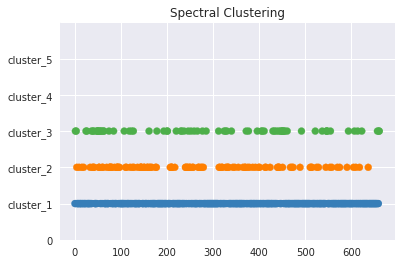

In [20]:
x = [data[i][0] for i in range(0, N)]
y = [data[j][1] for j in range(0, N)]
fig, ax = plt.subplots()

ax.scatter(x, y, color=colors[cluster_assignments])
ax.set_ylim(-1, 5)
ax.set_yticklabels(['0', 'cluster_1', 'cluster_2',
               'cluster_3', 'cluster_4',
               'cluster_5'])
ax.set_title("Spectral Clustering")
# fig.savefig('/home/somnus/data_sets/clusters/6artClus.jpg' + str(n_clusters), format='jpg')

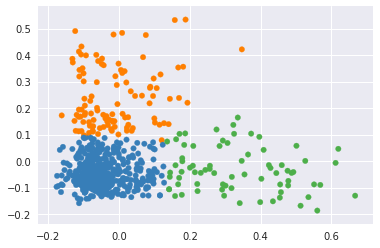

In [21]:
fig1, ax1 = plt.subplots()
ax1.scatter(data2D[:,0], data2D[:,1], s=30, color=colors[cluster_assignments])
# fig1.savefig('/home/somnus/data_sets/clusters/6art.jpg' + str(n_clusters), format='jpg')

In [22]:
range_n_clusters = [2, 3, 4, 5, 6, 7]

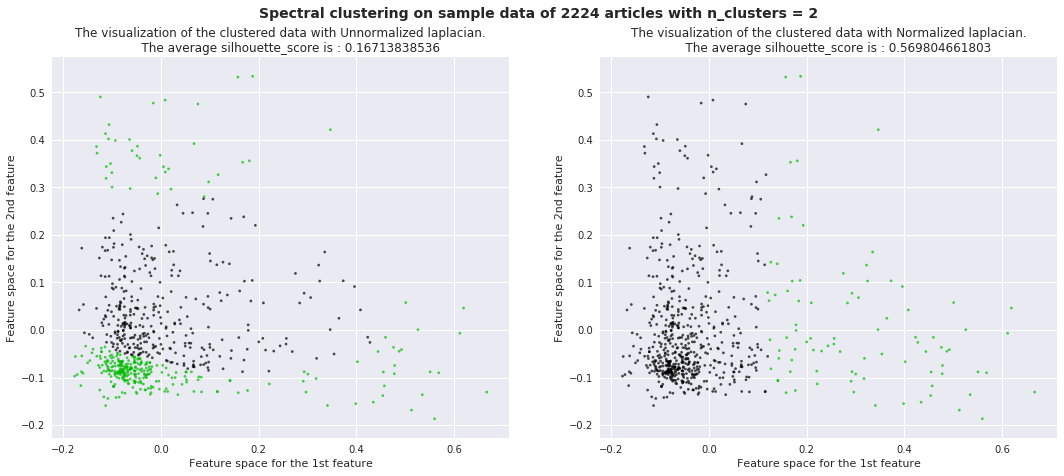

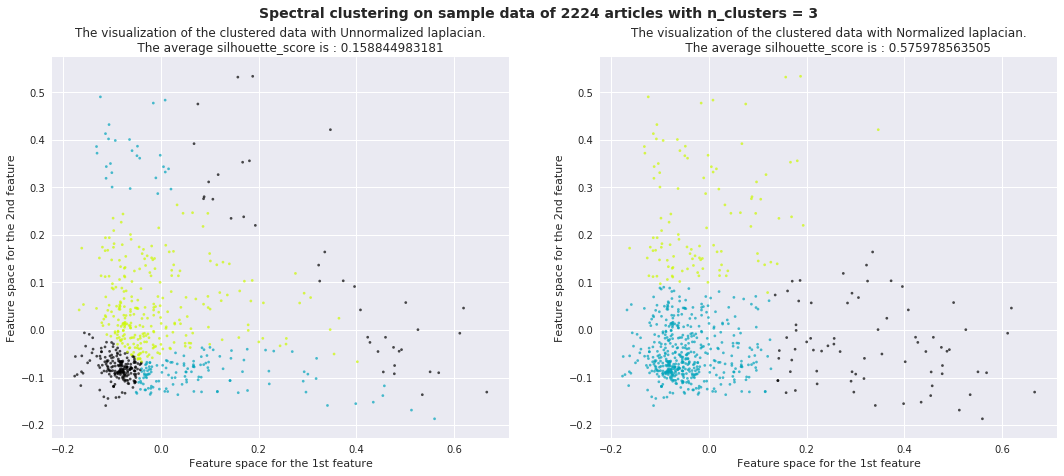

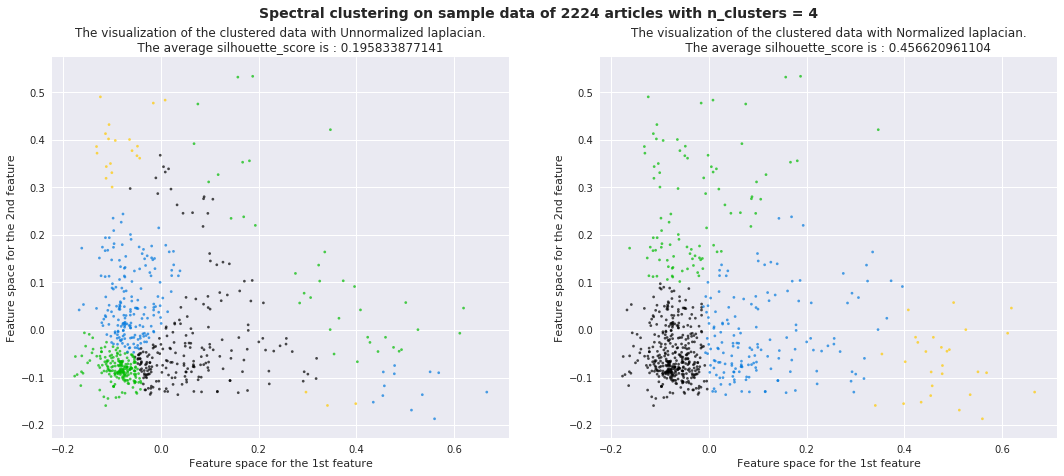

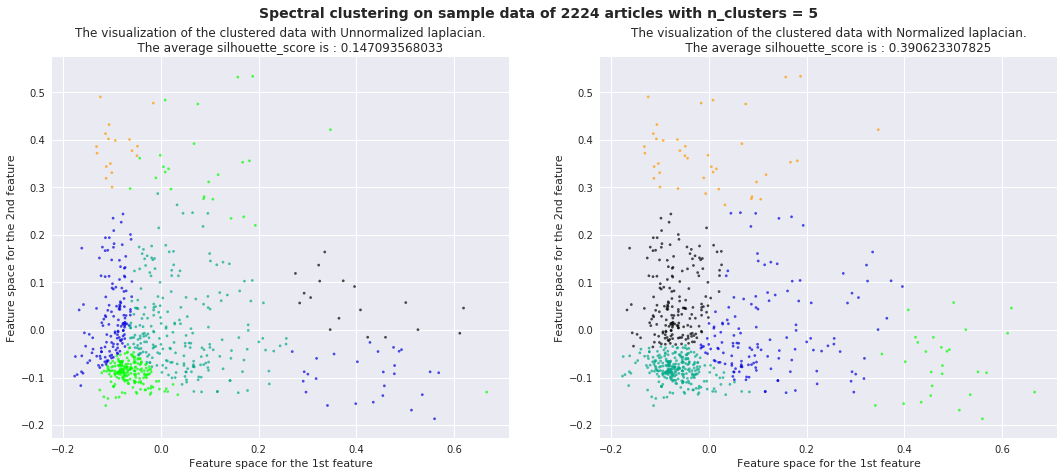

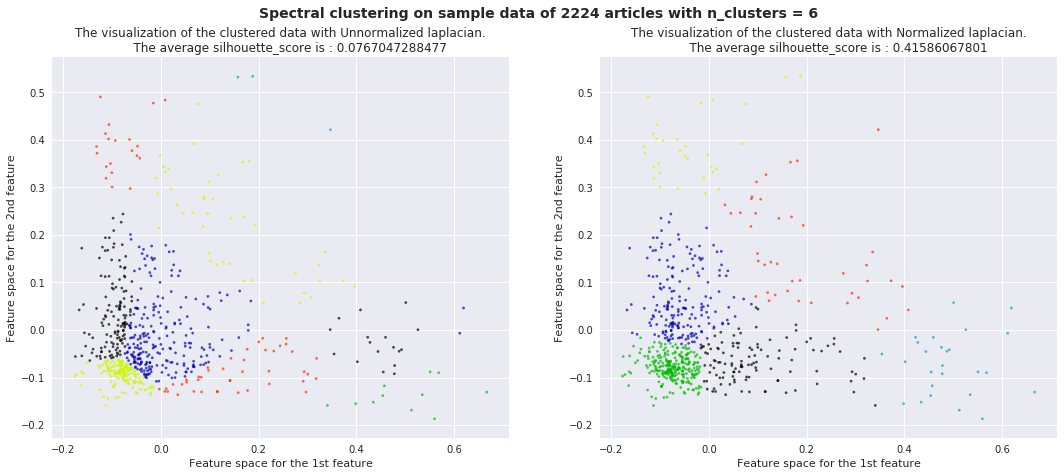

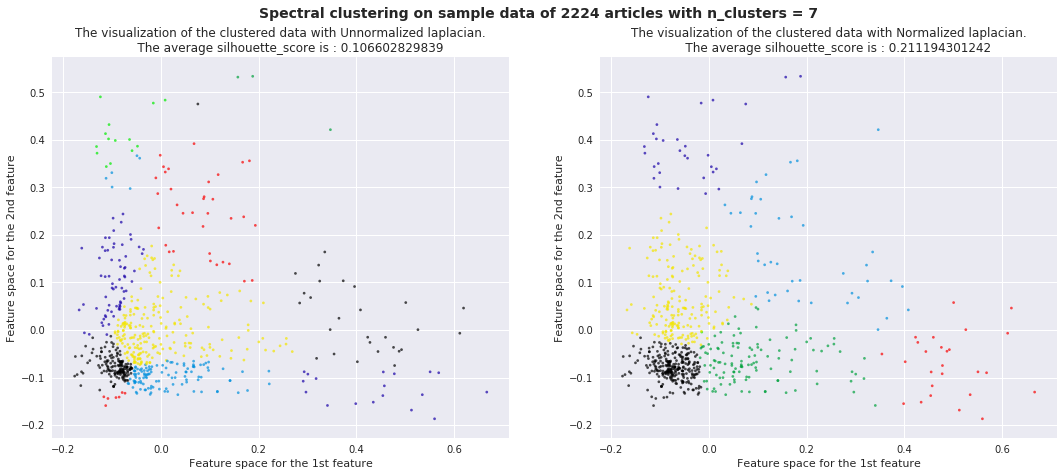

In [23]:
sil_norm = list()
sil_unNorm = list()

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels_norm = spectral_clustering(affinity_matrix_,
                                         n_clusters=n_clusters,
                                         eigen_solver=eigen_solver,
                                         random_state=random_state,
                                         n_init=n_init,
                                         eigen_tol=eigen_tol,
                                         assign_labels=assign_labels,
                                         normed='norm_laplacian')

    cluster_labels_unNorm = spectral_clustering(affinity_matrix_,
                                                n_clusters=n_clusters,
                                                eigen_solver=eigen_solver,
                                                random_state=random_state,
                                                n_init=n_init,
                                                eigen_tol=eigen_tol,
                                                assign_labels=assign_labels,
                                                normed=False
                                               )

    # Labeling the clusters
    # centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    # ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
    #            c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
     #   ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
     #               s=50, edgecolor='k')
    
   
    ##FOR UNNORMALIZED LAPLACIAN
    silhouette_avg_unNorm = silhouette_score(data2D, cluster_labels_unNorm)
    #print("For n_clusters =", n_clusters,
    #      "The average silhouette_score is :", silhouette_avg1)
    colors_unNorm = mpl.cm.spectral(cluster_labels_unNorm.astype(float) / n_clusters)
    ax1.scatter(data2D[:, 0], data2D[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors_unNorm, edgecolor='k')
    x_unNorm = "The visualization of the clustered data with Unnormalized laplacian.\n \
    The average silhouette_score is : " + str(silhouette_avg_unNorm)
    sil_unNorm.append(silhouette_avg_unNorm)
    
    #FOR NORMALIZED LAPLACIAN
    silhouette_avg_norm = silhouette_score(data2D, cluster_labels_norm)
    #print("For n_clusters =", n_clusters,
    #      "The average silhouette_score is :", silhouette_avg2)
    colors_norm = mpl.cm.spectral(cluster_labels_norm.astype(float) / n_clusters)
    ax2.scatter(data2D[:, 0], data2D[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors_norm, edgecolor='k')
    sil_norm.append(silhouette_avg_norm)

    x_norm = "The visualization of the clustered data with Normalized laplacian.\n \
    The average silhouette_score is : " + str(silhouette_avg_norm)
 
    
    ax1.set_title(x_unNorm)
    ax1.set_xlabel("Feature space for the 1st feature")
    ax1.set_ylabel("Feature space for the 2nd feature")


    ax2.set_title(x_norm)
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Spectral clustering on sample data of 2224 articles "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    fig.savefig('/home/somnus/data_sets/clusters/new_clus_'+str(n_clusters)+'.jpg')
    plt.show()
    

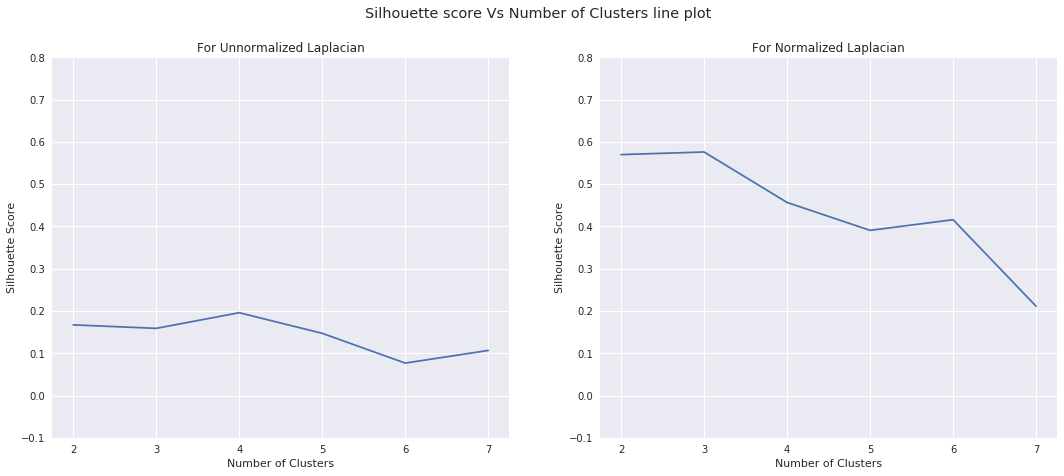

In [24]:

figN, (axUnN, axN) = plt.subplots(1,2)
figN.set_size_inches(18, 7)

plt.suptitle("Silhouette score Vs Number of Clusters line plot")

# For Unnormalized Laplacian
axUnN.plot(range_n_clusters, sil_unNorm)
axUnN.set_title("For Unnormalized Laplacian")
axUnN.set_xlabel("Number of Clusters")
axUnN.set_ylabel("Silhouette Score")
axUnN.set_yticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

# For Normalized Laplacian
axN.plot(range_n_clusters, sil_norm)
axN.set_title("For Normalized Laplacian")
axN.set_xlabel("Number of Clusters")
axN.set_ylabel("Silhouette Score")
axN.set_yticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

figN.savefig('/home/somnus/data_sets/clusters/silScore_VS_Clusters.jpg')
